In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg as la
import pywt
from numpy import fft
from scipy import signal
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter

In [2]:
DF = pd.read_csv('center_sternum.txt',sep='\t')
DF['Time'] = np.arange(0, len(DF['AccX']) )/DF['Log Freq'][0]    #changed freq
DF

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk,Time
0,5,200,1576222772,947.086,435.662,70.638,-6.824428,-14.244280,1.404580,-454,-490,-178,0.792622,0.254952,-0.553850,-0.000031,0.000
1,5,200,1576222772,969.168,387.777,88.877,6.183206,-12.290080,-7.969466,-454,-490,-177,0.736461,0.275124,-0.617969,0.006806,0.005
2,5,200,1576222772,989.603,380.335,78.751,11.709920,-4.961832,-7.450382,-454,-490,-177,0.729465,0.275246,-0.626118,0.009827,0.010
3,5,200,1576222772,954.894,418.033,88.328,17.877860,2.519084,-5.984733,-454,-492,-176,0.723413,0.277200,-0.632221,0.011383,0.015
4,5,200,1576222772,972.096,427.732,99.857,25.221370,5.404580,4.015267,-454,-492,-176,0.721948,0.280007,-0.632679,0.010193,0.020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16501,5,200,1576222847,958.493,291.092,-54.290,1.664122,2.305344,-0.671756,-494,-449,-126,0.650810,0.379162,-0.636402,0.166356,82.505
16502,5,200,1576222847,954.650,288.042,-49.654,1.480916,2.488550,-0.702290,-494,-450,-125,0.650239,0.379803,-0.636708,0.165960,82.510
16503,5,200,1576222847,967.338,290.482,-63.867,1.114504,3.374046,-0.900763,-494,-450,-125,0.649365,0.380627,-0.637227,0.165502,82.515
16504,5,200,1576222847,965.630,300.852,-56.242,0.702290,3.664122,-1.587786,-495,-448,-124,0.648973,0.381329,-0.637348,0.164953,82.520


In [3]:
a = 2500
b = 12500
df = DF.iloc[a:b+1]    
df = df.drop(['Log Mode', 'Log Freq', 'Timestamp','qw', 'qi', 'qj', 'qk'], axis=1)  
df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Time
2500,-31.415,107.055,-943.487,-2.549618,3.908397,-1.297710,-212,-434,434,12.500
2501,-19.276,110.166,-964.227,-2.610687,4.274809,-1.099237,-212,-434,434,12.505
2502,-33.855,105.835,-950.868,-2.503817,4.076336,-1.038168,-211,-435,434,12.510
2503,-37.332,108.580,-954.650,-2.167939,3.801527,-0.946565,-212,-434,434,12.515
2504,-39.894,106.323,-951.112,-1.908397,3.755725,-1.129771,-212,-434,434,12.520
...,...,...,...,...,...,...,...,...,...,...
12496,-24.034,116.266,-924.028,-1.389313,2.290076,-0.992366,-212,-430,427,62.480
12497,-38.186,124.989,-908.046,-0.122137,3.022901,-0.854962,-212,-430,427,62.485
12498,-36.600,122.366,-916.525,1.099237,3.053435,-0.916031,-211,-430,428,62.490
12499,-35.746,125.477,-975.634,0.122137,3.725191,-1.068702,-211,-430,428,62.495


In [4]:
gyro_off = np.array([-2.804399, 1.793105, 0.3411708])
acc_cal = np.array([[1.002982, 9.415505E-05, 0.004346743],
                    [9.04459E-05, 1.002731, -0.001444198], 
                    [0.004346536, -0.001444751,	1.030587]])
acc_off = np.array([3.602701, -20.96658, 54.97186])
magn_cal=np.array([[1.013437, -0.04728858, -0.001861475], 
                    [-0.04728862, 1.004832, 0.008222118],    
                    [-0.001861605, 0.008221965, 0.9439077]])
magn_off=np.array([-150.4098, 74.62431, 630.9805])

In [5]:
df[['GyroX','GyroY','GyroZ']]=df[['GyroX','GyroY','GyroZ']]+gyro_off.T
df[['AccX','AccY','AccZ']]=np.dot(df[['AccX','AccY','AccZ']],acc_cal.T)+acc_off.T
df[['MagnX','MagnY','MagnZ']]=np.dot(df[['MagnX','MagnY','MagnZ']],magn_cal.T)+magn_off.T
df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Time
2500,-31.996994,87.740528,-917.664791,-5.354017,5.701502,-0.956539,-345.543080,-347.879191,1037.462769,12.500
2501,-19.911654,90.891075,-938.990898,-5.415086,6.067914,-0.758066,-345.543080,-347.879191,1037.462769,12.505
2502,-34.476469,86.527635,-925.280397,-5.308216,5.869441,-0.696997,-344.482355,-348.931312,1037.452686,12.510
2503,-37.980018,89.285279,-929.197155,-4.972338,5.594632,-0.605394,-345.543080,-347.879191,1037.462769,12.515
2504,-40.534491,87.016774,-925.558814,-4.712796,5.548830,-0.788600,-345.543080,-347.879191,1037.462769,12.520
...,...,...,...,...,...,...,...,...,...,...
12496,-24.508534,96.949248,-897.591825,-4.193712,4.083181,-0.651196,-345.719204,-343.917418,1030.888303,62.480
12497,-38.632444,105.671709,-881.195098,-2.926536,4.816006,-0.513791,-345.719204,-343.917418,1030.888303,62.485
12498,-37.078817,103.053935,-889.922762,-1.705162,4.846540,-0.574860,-344.707629,-343.956485,1031.830349,62.490
12499,-36.478910,106.258873,-950.840511,-2.682262,5.518296,-0.727531,-344.707629,-343.956485,1031.830349,62.495


In [6]:
stat_df = pd.DataFrame({
    'mean'  : df.mean(),
    'median': df.median(),
    'variance': df.var(),
    'standard deviation': df.std(),
    '25% percentile' : df.quantile(q=0.25),
    '75% percentile': df.quantile(q=0.75)
    }).T
stat_df.drop(['Time'], axis=1)

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
mean,-30.964630,96.077508,-923.854076,-4.894245,5.481664,-0.527252,-345.351984,-346.324950,1033.697389
median,-30.887292,96.240514,-924.333618,-4.957071,5.441960,-0.513791,-345.543080,-346.021659,1033.695360
variance,48.650342,27.940991,218.892661,2.033915,0.517204,0.132337,1.806120,2.416150,7.003315
standard deviation,6.974980,5.285924,14.795022,1.426154,0.719169,0.363781,1.343920,1.554397,2.646378
25% percentile,-35.550164,92.624450,-932.505348,-5.491422,5.075548,-0.773333,-346.550933,-347.831903,1031.813905
75% percentile,-26.330325,99.549184,-916.003019,-4.285315,5.808372,-0.284783,-344.571348,-344.969539,1036.510640


In [7]:
dfc = df - stat_df.iloc[0]
dfc['Time'] = df['Time']
dfc

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Time
2500,-1.032364,-8.336980,6.189285,-0.459772,0.219838,-0.429287,-0.191096,-1.554241,3.765380,12.500
2501,11.052976,-5.186433,-15.136821,-0.520841,0.586250,-0.230814,-0.191096,-1.554241,3.765380,12.505
2502,-3.511839,-9.549873,-1.426320,-0.413971,0.387777,-0.169745,0.869629,-2.606362,3.755297,12.510
2503,-7.015388,-6.792229,-5.343079,-0.078093,0.112968,-0.078142,-0.191096,-1.554241,3.765380,12.515
2504,-9.569862,-9.060734,-1.704737,0.181449,0.067166,-0.261348,-0.191096,-1.554241,3.765380,12.520
...,...,...,...,...,...,...,...,...,...,...
12496,6.456096,0.871740,26.262252,0.700533,-1.398483,-0.123943,-0.367220,2.407532,-2.809086,62.480
12497,-7.667814,9.594201,42.658979,1.967709,-0.665658,0.013461,-0.367220,2.407532,-2.809086,62.485
12498,-6.114188,6.976427,33.931315,3.189083,-0.635124,-0.047607,0.644355,2.368466,-1.867040,62.490
12499,-5.514280,10.181365,-26.986435,2.211983,0.036632,-0.200279,0.644355,2.368466,-1.867040,62.495


In [8]:
sigx = dfc['GyroX']
sigy = dfc['GyroY']
sigz = dfc['GyroZ']
t = dfc['Time']

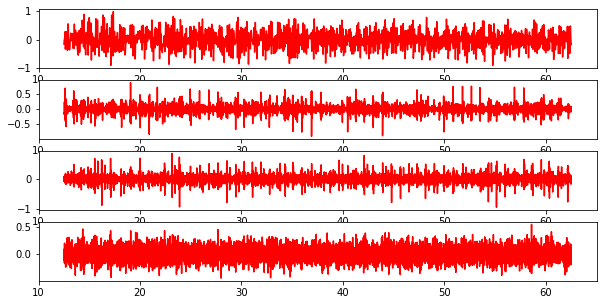

In [9]:
import pywt
n = 3
coeffs_z = pywt.wavedec(sigz, 'bior5.5', level = n)
sigs = np.zeros((n+1,len(t)+1))
for i in range(n+1):
    ca = coeffs_z.copy()
    for j in range(n+1):
        if j != i: 
            ca[j] = np.zeros_like(ca[j])
    sigs[i] = pywt.waverec(ca, 'bior5.5')

ax = []
fig, ax = plt.subplots(nrows = n+1, ncols = 1, figsize = (10, 5))
for i in range(n+1):
    ax[i].plot(t, sigs[i][:-1], color = 'red')

(30.0, 40.0)

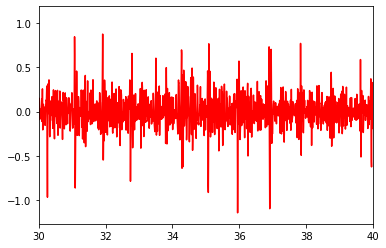

In [10]:
ca = coeffs_z.copy()
for j in range(n+1):
    if (j!=2) & (j!=1): 
        ca[j] = np.zeros_like(ca[j])
sigz_w = pywt.waverec(ca, 'bior5.5')
plt.plot(t, (sigz_w[:-1]), color = 'red')
plt.xlim(30, 40)

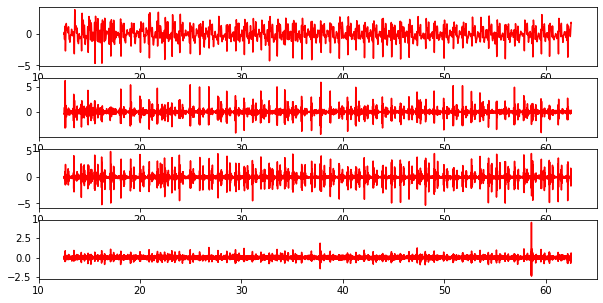

In [11]:
n = 3
coeffs_x = pywt.wavedec(sigx, 'bior5.5', level = n)
sigs = np.zeros((n+1,len(t)+1))
for i in range(n+1):
    ca = coeffs_x.copy()
    for j in range(n+1):
        if j != i: 
            ca[j] = np.zeros_like(ca[j])
    sigs[i] = pywt.waverec(ca, 'bior5.5')

ax = []
fig, ax = plt.subplots(nrows = n+1, ncols = 1, figsize = (10, 5))
for i in range(n+1):
    ax[i].plot(t, sigs[i][:-1], color = 'red')

(30.0, 40.0)

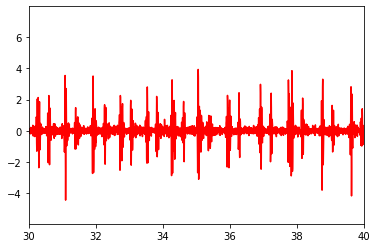

In [12]:
ca = coeffs_x.copy()
for j in range(n+1):
    if (j!=3) & (j!=2): 
        ca[j] = np.zeros_like(ca[j])
sigx_w = pywt.waverec(ca, 'bior5.5')
plt.plot(t, (sigx_w[:-1]), color = 'red')
plt.xlim(30, 40)

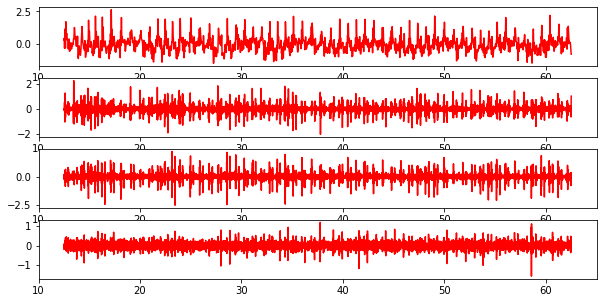

In [13]:
n = 3
coeffs_y = pywt.wavedec(sigy, 'bior5.5', level = n)
sigs = np.zeros((n+1,len(t)+1))
for i in range(n+1):
    ca = coeffs_y.copy()
    for j in range(n+1):
        if j != i: 
            ca[j] = np.zeros_like(ca[j])
    sigs[i] = pywt.waverec(ca, 'bior5.5')

ax = []
fig, ax = plt.subplots(nrows = n+1, ncols = 1, figsize = (10, 5))
for i in range(n+1):
    ax[i].plot(t, sigs[i][:-1], color = 'red')

(30.0, 40.0)

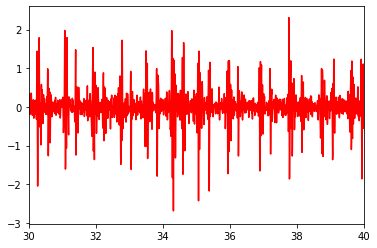

In [14]:
ca = coeffs_y.copy()
for j in range(n+1):
    if (j!=1) & (j!=2): 
        ca[j] = np.zeros_like(ca[j])
sigy_w = pywt.waverec(ca, 'bior5.5')
plt.plot(t, (sigy_w[:-1]), color = 'red')
plt.xlim(30, 40)

(20.0, 30.0)

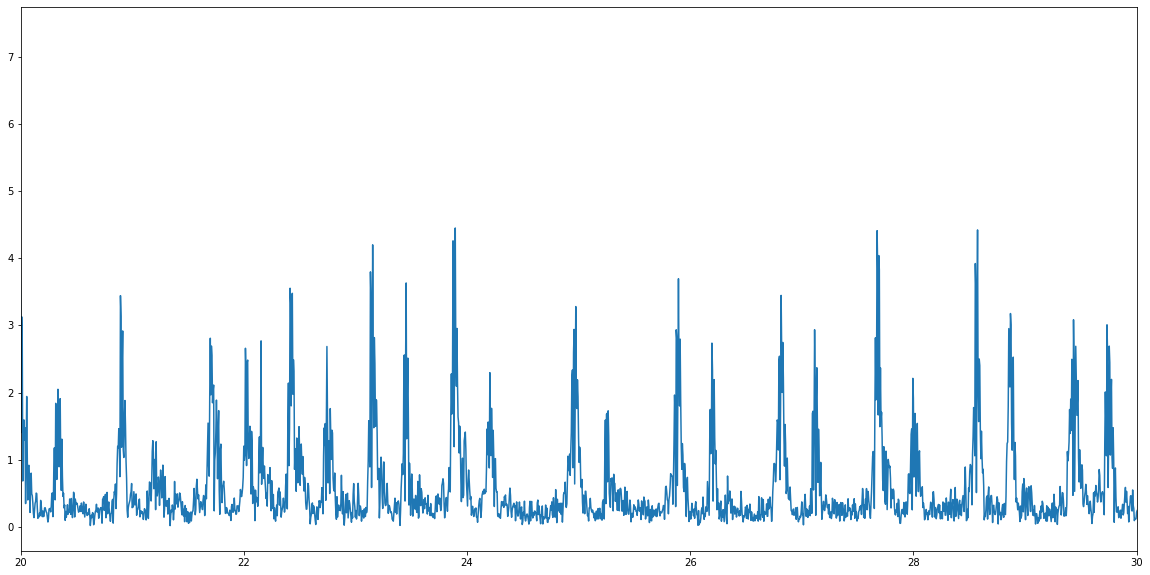

In [15]:
%matplotlib inline
SIG = (sigz_w**2+sigx_w**2+sigy_w**2)**0.5
plt.figure(figsize=(20,10))
plt.plot(t, SIG[:-1])
plt.xlim(20, 30)

(22.0, 24.0)

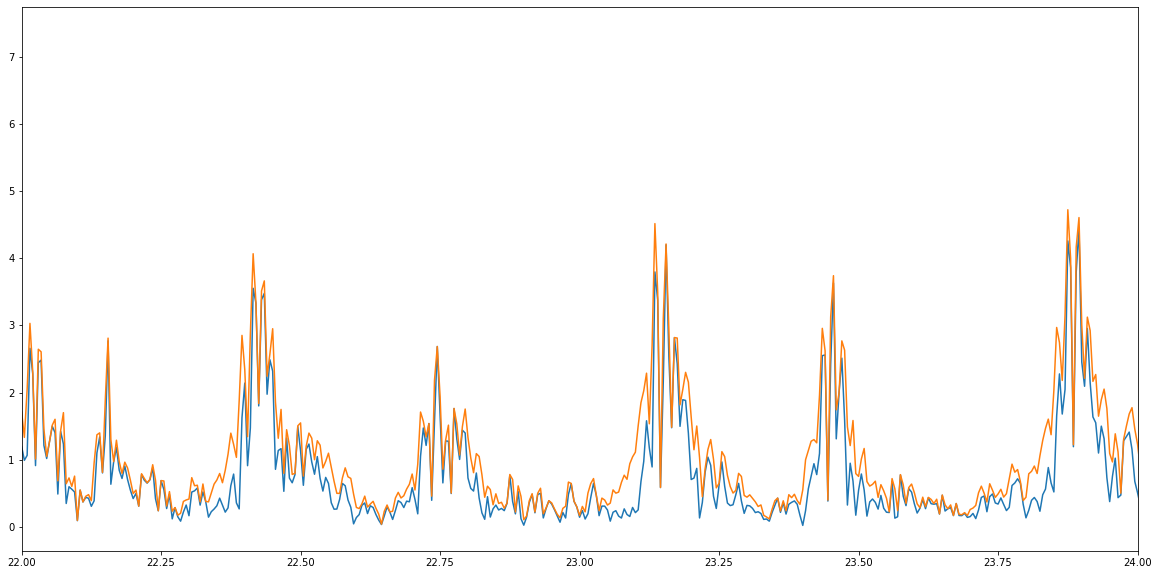

In [16]:
SIG_h = signal.hilbert(SIG)
plt.figure(figsize=(20,10))
plt.plot(t, SIG[:-1])
plt.plot(t, np.abs(SIG_h[:-1]))
plt.xlim(22, 24)

(20.0, 35.0)

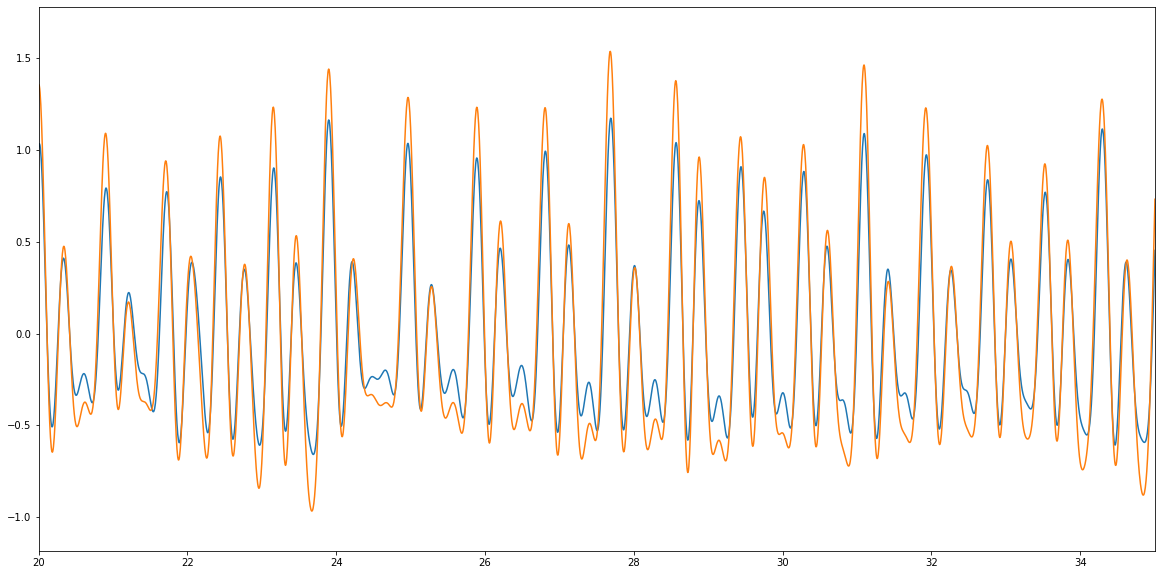

In [17]:
#fc = 35 
#w = fc / (200 / 2) #cut-off frequency
b, a = signal.butter(4, Wn=[0.67/100, 4/100], btype='bandpass')
filtered_data_butterworth = signal.filtfilt(b, a, np.abs(SIG))
filtered_data_butterworth_2 = signal.filtfilt(b, a, np.abs(SIG_h))
plt.figure(figsize=(20,10))
plt.plot(t, filtered_data_butterworth[:-1])
plt.plot(t, filtered_data_butterworth_2[:-1])
plt.xlim(20, 35)

## Find peaks

In [18]:
def histo_func(bins1,peaks1,t):
    from matplotlib.gridspec import GridSpec
    from lmfit.models import GaussianModel
    peaks_time1=t[peaks1]
    period1 = peaks_time1[1:]-peaks_time1[:-1]
    rate1 = 1/period1*60

    fig = plt.figure(figsize=(12,6))
    gs = GridSpec(3,3)

    ax_main = fig.add_subplot(gs[:,:2])
    ax_marg = fig.add_subplot(gs[:,2])
    ax_main.plot((peaks_time1[1:]+peaks_time1[:-1])*0.5,rate1,'r-o')
    ax_main.set_xlabel('Time (s)')
    ax_main.set_ylabel('Heart BPM')
    ax_main.set_title('Heart BPM as a function of time and histogram')
    l=ax_main.get_ylim()
    h1,b1,_=ax_marg.hist(x=rate1, bins=bins1,orientation='horizontal', color='red')
    bin_center1=(b1[1:]+b1[:-1])*0.5
    ax_marg.set_ylim(l)

    mod1 = GaussianModel(prefix='g_')
    pars1 = mod1.guess(h1, x=bin_center1)
    out1 = mod1.fit(h1, pars1, x=bin_center1)
    #print(out.params)
    #ax_marg.plot(out.best_fit, bin_center, 'r-', label='best fit')
    print(out1.params['g_center'].value, out1.params['g_center'].stderr)
    print(out1.params['g_sigma'].value, out1.params['g_sigma'].stderr)


In [19]:
data=filtered_data_butterworth_2[:-1]

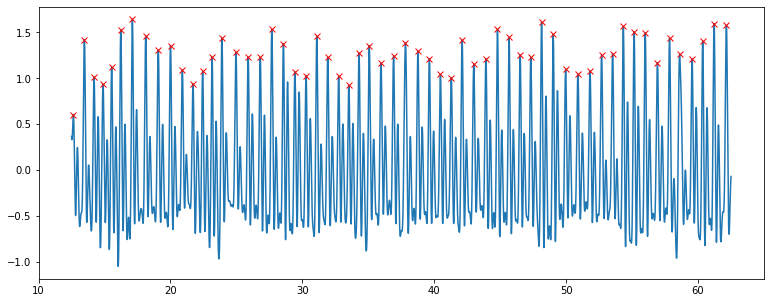

In [22]:
%matplotlib inline
plt.figure(figsize=(13,5))
plt.plot(t,data)
peaks1,_ = signal.find_peaks(data, height=0.3 , distance=90,threshold=None, prominence=None)
# #print(peaks)
plt.plot(t.values[peaks1],data[peaks1], 'rx')
#plt.ylim(0,4)
#peaks2,_=signal.find_peaks(-data, height=6, distance=55)
#plt.plot(t[peaks2],data[peaks2], 'gx')

69.12104419157531 0.9401357485065254
5.745033077889158 0.9589886944392568


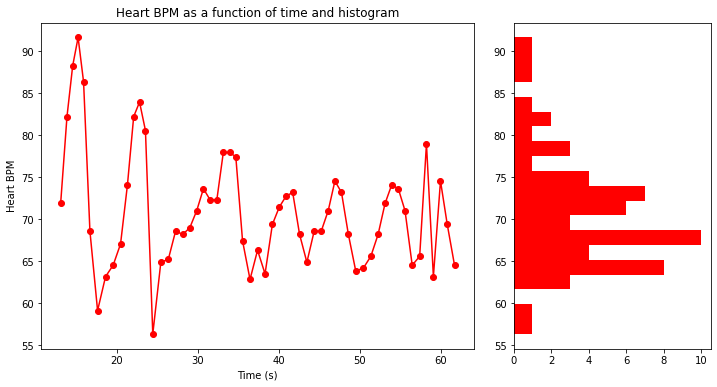

In [23]:
histo_func(20,peaks1,t.values)